# Forecast of O3 data: LSTM

## Introduction

**Purpose:** This notebook is used to train a long short-term memory (LSTM) neural network to generate a 24-hour ozone forecast.

**Contents:** The notebook contains:
* Model training
* Validation of the model
* Determination of the model's accuracy at 1-, 12-, and 24-hour horizons.

**Conclusions:** Key conclusions & outputs are:
* The fully trained model is exported as `model_24h` for subsequent deployment.
* The model qualitatively captures the general seasonality of the data, both on a daily horizon and longer.
* Predictions at a 1-hour horizon have a mean error of 4.1 ppb. Errors at a 12- or 24-hour horizon are greater (9.1 and 8.6 ppb, respectively).

## Import required modules

In [1]:
import numpy as np
import pandas as pd

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from datetime import datetime

2022-07-03 13:25:00.132044: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-03 13:25:00.132093: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Import data sets

The processed data sets were previously saved as a single set of compressed numpy arrays. Read them as a dict, `ds`.

In [3]:
compressed = np.load("O3_model/transformed_datasets_24h_horizon.npz",
             allow_pickle = True)

In [4]:
compressed.files

['x_train', 'x_test', 'y_train', 'y_test', 'dt_train', 'dt_test']

In [5]:
# Force arrays into float32 types; otherwise, Keras is unhappy.
ds = {}
for array in ['x_train', 'x_test', 'y_train', 'y_test']:
    ds[array] = compressed[array].astype(np.float32)

In [6]:
ds["y_train"][0].shape, ds["x_train"][0].shape

((24,), (25, 4))

In [7]:
ds["dt_test"] = compressed["dt_test"].astype(np.datetime64)

## Train & evaluate a simple model

In [8]:
calls = [EarlyStopping(monitor = "val_loss",
                       patience = 3)]

In [9]:
model = Sequential()
model.add(LSTM(units = 50,
                    activation = "tanh",
                    input_shape = (ds["x_train"].shape[1],
                               ds["x_train"].shape[2])
                    ))
model.add(Dense(24))
model.compile(loss = "mse",
                        metrics = ["mse", "mae"],
                        optimizer = "adam")

2022-07-03 13:25:07.654120: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-03 13:25:07.654185: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-03 13:25:07.654220: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dwarven-notebook): /proc/driver/nvidia/version does not exist
2022-07-03 13:25:07.654837: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


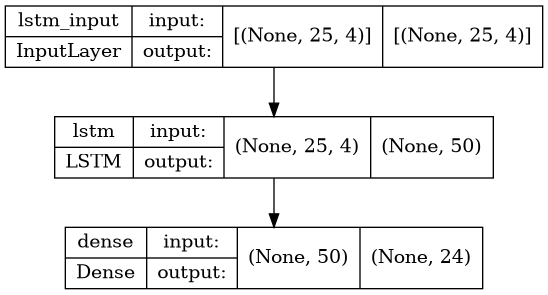

In [10]:
plot_model(model,
           show_shapes = True,
           expand_nested = True)

In [11]:
history = model.fit(ds["x_train"],
                    ds["y_train"],
                    epochs = 20,
                    batch_size = 32,
                    verbose = 1,
                    validation_data = (ds["x_test"], ds["y_test"]),
                    shuffle = False,
                    callbacks = calls)

Epoch 1/20
3682/3682 [==============================] - 67s 17ms/step - loss: 328.9284 - mse: 328.9284 - mae: 14.7319 - val_loss: 331.6767 - val_mse: 331.6767 - val_mae: 15.1501
Epoch 2/20
3682/3682 [==============================] - 65s 18ms/step - loss: 253.8441 - mse: 253.8441 - mae: 12.6952 - val_loss: 216.4477 - val_mse: 216.4477 - val_mae: 11.8937
Epoch 3/20
3682/3682 [==============================] - 59s 16ms/step - loss: 140.0699 - mse: 140.0699 - mae: 8.8934 - val_loss: 163.6605 - val_mse: 163.6605 - val_mae: 10.0657
Epoch 4/20
3682/3682 [==============================] - 66s 18ms/step - loss: 116.4782 - mse: 116.4782 - mae: 7.9777 - val_loss: 159.1231 - val_mse: 159.1231 - val_mae: 9.8988
Epoch 5/20
3682/3682 [==============================] - 69s 19ms/step - loss: 107.0958 - mse: 107.0958 - mae: 7.5910 - val_loss: 153.3810 - val_mse: 153.3810 - val_mae: 9.6938
Epoch 6/20
3682/3682 [==============================] - 66s 18ms/step - loss: 102.0152 - mse: 102.0152 - mae: 7.377

In [12]:
model.save("O3_model/model_24h")

2022-07-03 13:46:50.706566: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: O3_model/model_24h/assets


INFO:tensorflow:Assets written to: O3_model/model_24h/assets


In [13]:
history_df = pd.DataFrame(history.history)

<AxesSubplot:>

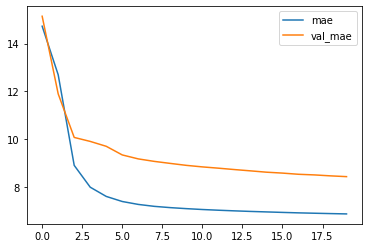

In [14]:
history_df.plot(kind = "line", y = ["mae", "val_mae"])

In [15]:
preds = pd.DataFrame(model.predict(ds["x_test"]))

In [16]:
preds.columns = ["Pred" + str(hour) + "h" for hour in range(1, len(preds.columns) + 1)]
preds.head()

,Pred1h,Pred2h,Pred3h,Pred4h,Pred5h,Pred6h,Pred7h,Pred8h,Pred9h,Pred10h,...,Pred15h,Pred16h,Pred17h,Pred18h,Pred19h,Pred20h,Pred21h,Pred22h,Pred23h,Pred24h
0,20.019449,22.759806,26.724905,32.095016,38.492828,45.102726,50.938976,55.361649,57.530178,57.110065,...,36.493027,32.935452,30.421427,28.226307,26.539518,24.622971,22.378580,20.127943,18.402233,17.962584
1,27.517721,30.532520,34.664410,39.816006,45.718113,51.289818,55.144398,57.092773,56.455456,53.650661,...,32.658131,30.215706,28.974012,27.543314,26.274717,24.331821,22.218319,20.160393,19.086689,19.890314
2,31.637650,35.684212,40.296326,45.145752,50.033466,53.923542,55.937683,56.224335,54.377586,50.960358,...,30.662580,28.115997,26.478802,24.831921,23.603395,22.006435,20.732855,19.811903,20.237488,22.481022
3,39.297207,44.031364,48.622475,52.410477,55.413651,56.823402,56.548141,54.865234,51.840714,47.968052,...,30.397863,27.733061,25.522875,23.610727,22.251019,21.051208,20.668196,21.143604,23.182571,27.201082
4,44.984978,49.448986,53.261192,55.814640,57.071953,56.681461,55.147366,52.403366,49.138493,45.480354,...,30.336889,27.755287,25.472433,23.722855,22.613113,22.129612,22.552664,24.153437,27.259647,32.044701


In [17]:
y_test = pd.DataFrame(ds["y_test"])
y_test.columns = ["Meas" + str(hour) + "h" for hour in range(1, len(y_test.columns) + 1)]
preds = pd.concat([preds, y_test], axis = "columns", ignore_index = False)

In [18]:
preds.head()

,Pred1h,Pred2h,Pred3h,Pred4h,Pred5h,Pred6h,Pred7h,Pred8h,Pred9h,Pred10h,...,Meas15h,Meas16h,Meas17h,Meas18h,Meas19h,Meas20h,Meas21h,Meas22h,Meas23h,Meas24h
0,20.019449,22.759806,26.724905,32.095016,38.492828,45.102726,50.938976,55.361649,57.530178,57.110065,...,39.0,38.0,39.0,37.0,38.0,37.0,39.0,33.0,30.0,19.0
1,27.517721,30.532520,34.664410,39.816006,45.718113,51.289818,55.144398,57.092773,56.455456,53.650661,...,38.0,39.0,37.0,38.0,37.0,39.0,33.0,30.0,19.0,17.0
2,31.637650,35.684212,40.296326,45.145752,50.033466,53.923542,55.937683,56.224335,54.377586,50.960358,...,39.0,37.0,38.0,37.0,39.0,33.0,30.0,19.0,17.0,19.0
3,39.297207,44.031364,48.622475,52.410477,55.413651,56.823402,56.548141,54.865234,51.840714,47.968052,...,37.0,38.0,37.0,39.0,33.0,30.0,19.0,17.0,19.0,22.0
4,44.984978,49.448986,53.261192,55.814640,57.071953,56.681461,55.147366,52.403366,49.138493,45.480354,...,38.0,37.0,39.0,33.0,30.0,19.0,17.0,19.0,22.0,25.0


In [19]:
preds["DateTime"] = ds["dt_test"]

## Compare predictions at different horizons in the future

### Forecast 1 hour

<AxesSubplot:title={'center':'1-hour Ozone Predictions'}, xlabel='Date & Time', ylabel='Ozone Concentration (ppb)'>

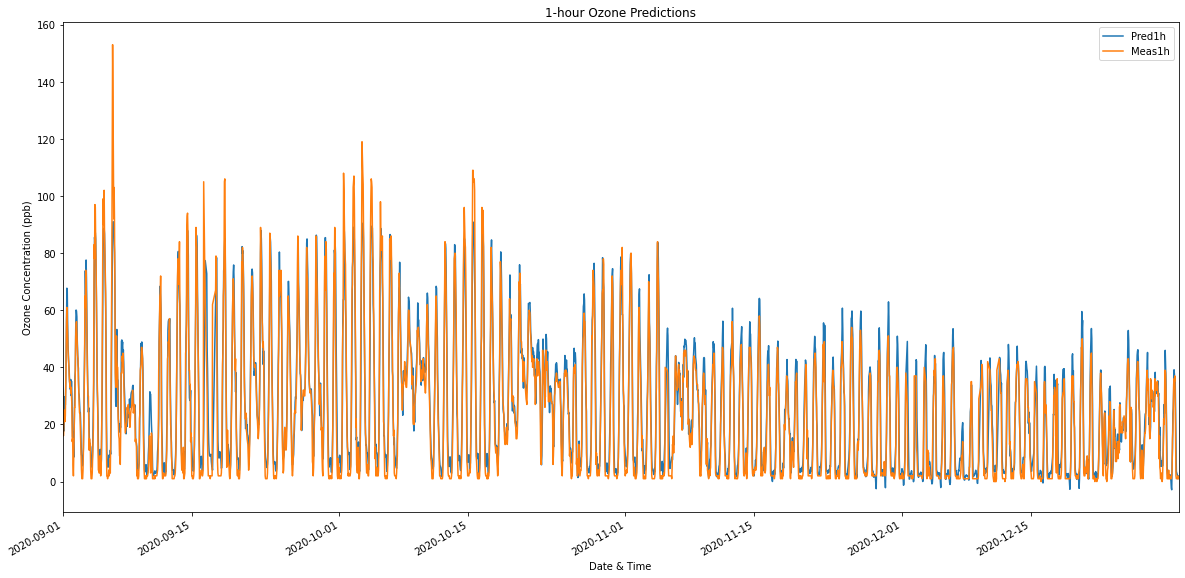

In [20]:
preds.plot(kind = "line",
           y = ["Pred1h", "Meas1h"],
           x = "DateTime",
           title = "1-hour Ozone Predictions",
           xlabel = "Date & Time",
           ylabel = "Ozone Concentration (ppb)",
           figsize = (20, 10),
           xlim = (datetime(2020, 9, 1), datetime(2020, 12, 31)),
           subplots = False)

### Forecast 6 hours

<AxesSubplot:title={'center':'6-hour Ozone Predictions'}, xlabel='Date & Time', ylabel='Ozone Concentration (ppb)'>

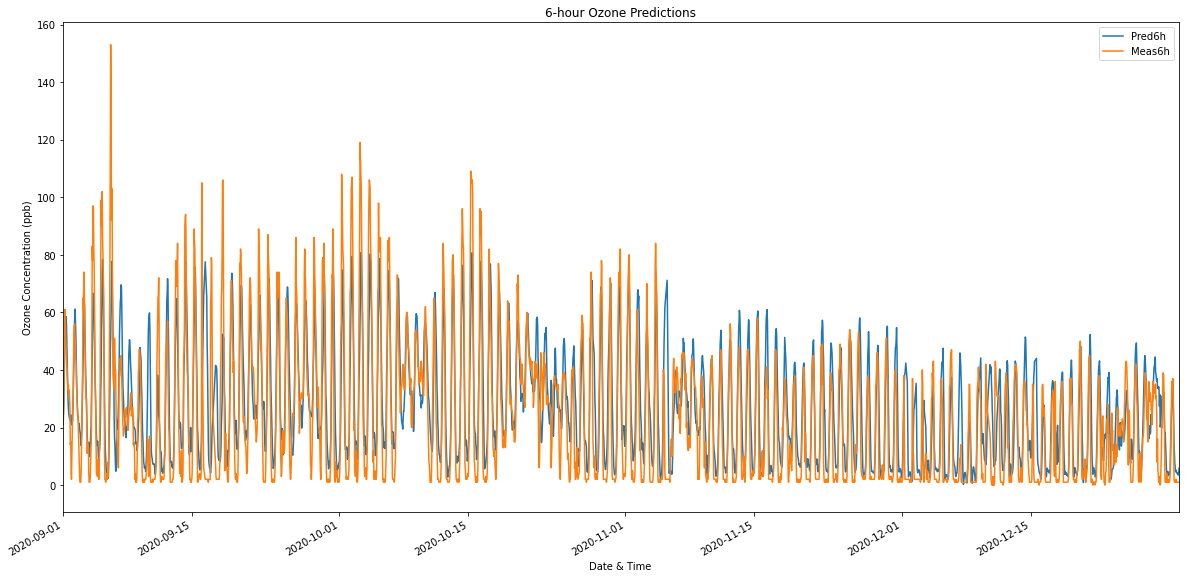

In [21]:
preds.plot(kind = "line",
           y = ["Pred6h", "Meas6h"],
           x = "DateTime",
           title = "6-hour Ozone Predictions",
           xlabel = "Date & Time",
           ylabel = "Ozone Concentration (ppb)",
           figsize = (20, 10),
           xlim = (datetime(2020, 9, 1), datetime(2020, 12, 31)),
           subplots = False)

### Forecast 12 hours

<AxesSubplot:title={'center':'12-hour Ozone Predictions'}, xlabel='Date & Time', ylabel='Ozone Concentration (ppb)'>

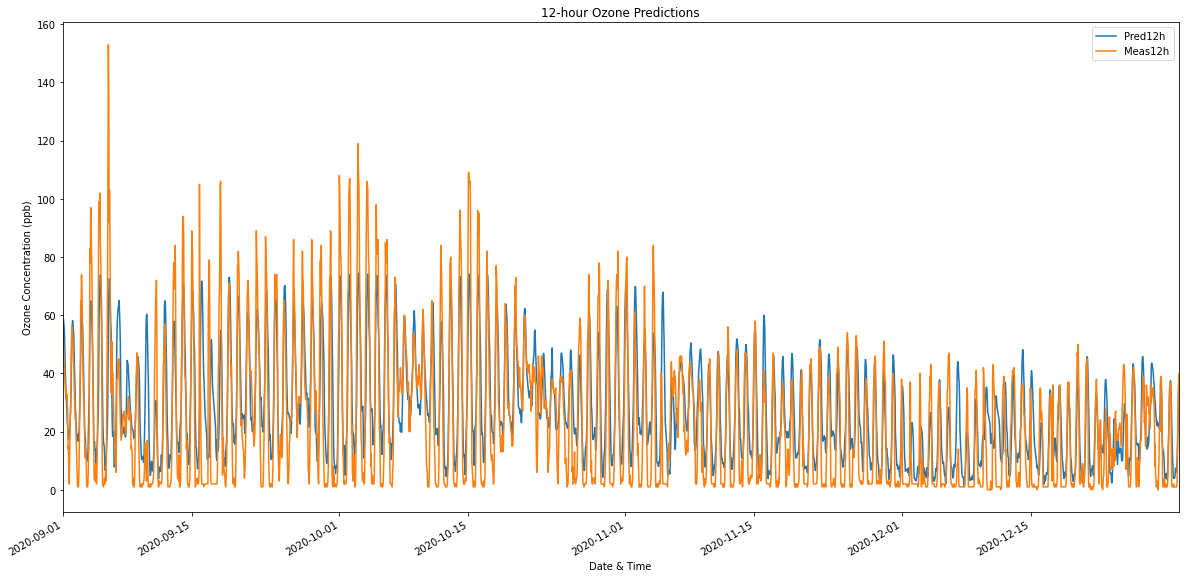

In [22]:
preds.plot(kind = "line",
           y = ["Pred12h", "Meas12h"],
           x = "DateTime",
           title = "12-hour Ozone Predictions",
           xlabel = "Date & Time",
           ylabel = "Ozone Concentration (ppb)",
           figsize = (20, 10),
           xlim = (datetime(2020, 9, 1), datetime(2020, 12, 31)),
           subplots = False)

### Forecast 24 hours

<AxesSubplot:title={'center':'24-hour Ozone Predictions'}, xlabel='Date & Time', ylabel='Ozone Concentration (ppb)'>

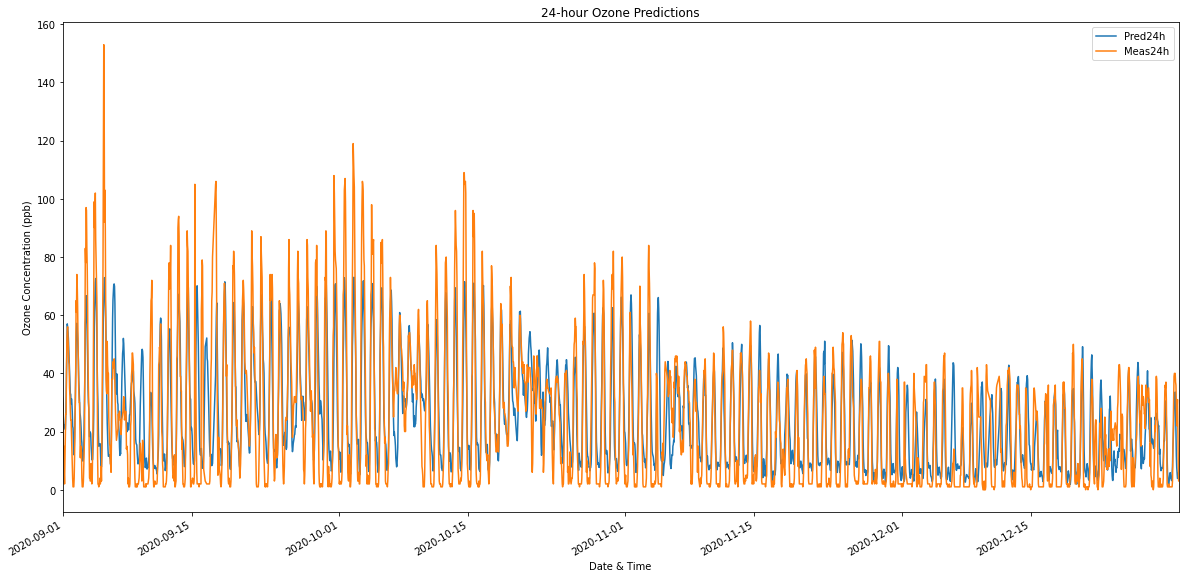

In [25]:
preds.plot(kind = "line",
           y = ["Pred24h", "Meas24h"],
           x = "DateTime",
           title = "24-hour Ozone Predictions",
           xlabel = "Date & Time",
           ylabel = "Ozone Concentration (ppb)",
           figsize = (20, 10),
           xlim = (datetime(2020, 9, 1), datetime(2020, 12, 31)),
           subplots = False)

### Parity plot at a 1-hour horizon

<AxesSubplot:title={'center':'Parity Plot for 1-Hour Ozone Forecast'}, xlabel='Measured Ozone Concentration (ppb)', ylabel='Predicted Ozone Concentration (ppb)'>

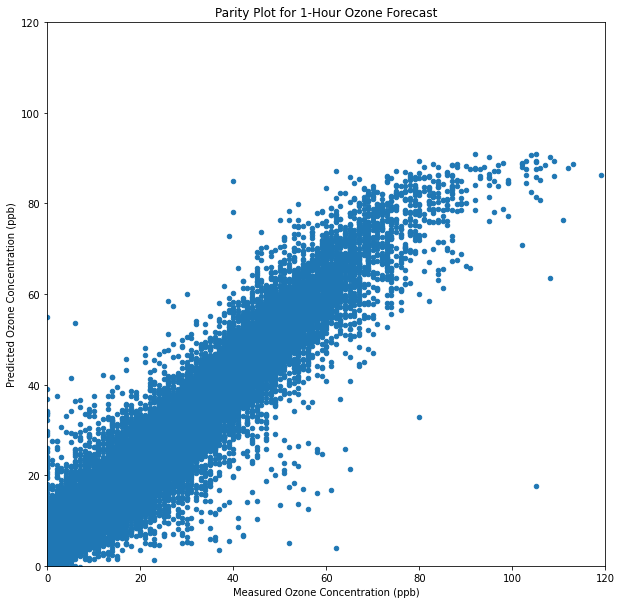

In [28]:
preds.plot(kind = "scatter",
           x = "Meas1h",
           y = "Pred1h",
           title = "Parity Plot for 1-Hour Ozone Forecast",
           xlabel = "Measured Ozone Concentration (ppb)",
           ylabel = "Predicted Ozone Concentration (ppb)",
           figsize = (10, 10),
           xlim = (0, 120),
           ylim = (0, 120),
           subplots = False)

Absolute error for 1-hour forecast:

In [45]:
print("Mean absolute error: ", abs(preds["Pred1h"] - preds["Meas1h"]).mean())

Mean absolute error:  4.100658


### Parity plot at a 12-hour horizon

<AxesSubplot:title={'center':'Parity Plot for 12-Hour Ozone Forecast'}, xlabel='Measured Ozone Concentration (ppb)', ylabel='Predicted Ozone Concentration (ppb)'>

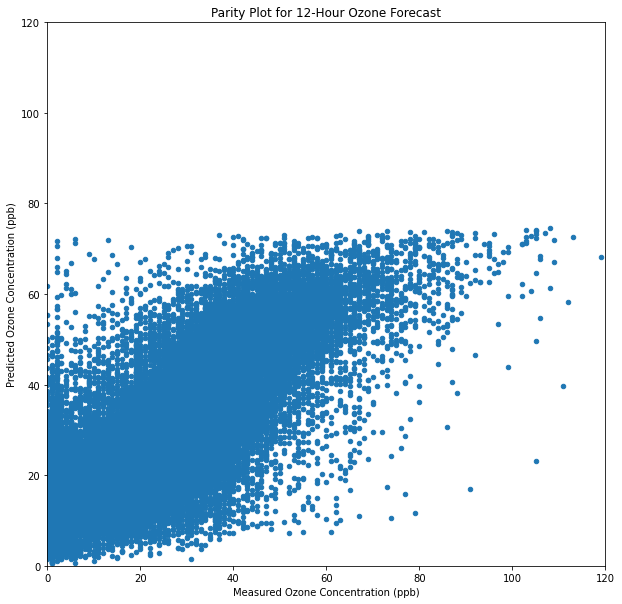

In [46]:
preds.plot(kind = "scatter",
           x = "Meas12h",
           y = "Pred12h",
           title = "Parity Plot for 12-Hour Ozone Forecast",
           xlabel = "Measured Ozone Concentration (ppb)",
           ylabel = "Predicted Ozone Concentration (ppb)",
           figsize = (10, 10),
           xlim = (0, 120),
           ylim = (0, 120),
           subplots = False)

Absolute error for 1-hour forecast:

In [47]:
print("Mean absolute error: ", abs(preds["Pred12h"] - preds["Meas12h"]).mean())

Mean absolute error:  9.246972


### Parity plot at a 24-hour horizon

<AxesSubplot:title={'center':'Parity Plot for 24-Hour Ozone Forecast'}, xlabel='Measured Ozone Concentration (ppb)', ylabel='Predicted Ozone Concentration (ppb)'>

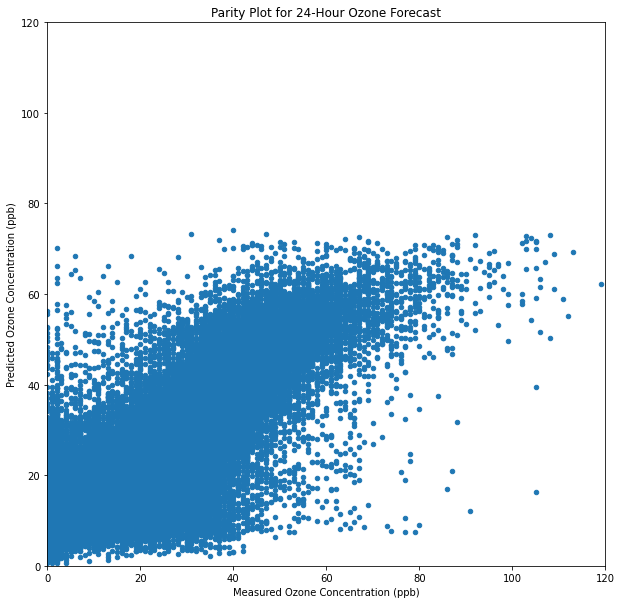

In [48]:
preds.plot(kind = "scatter",
           x = "Meas24h",
           y = "Pred24h",
           title = "Parity Plot for 24-Hour Ozone Forecast",
           xlabel = "Measured Ozone Concentration (ppb)",
           ylabel = "Predicted Ozone Concentration (ppb)",
           figsize = (10, 10),
           xlim = (0, 120),
           ylim = (0, 120),
           subplots = False)

Absolute error for 1-hour forecast:

In [49]:
print("Mean absolute error: ", abs(preds["Pred24h"] - preds["Meas24h"]).mean())

Mean absolute error:  8.573812


## Takeaways

The model is quite good at capturing the general seasonality of the data, both on a daily horizon and longer.

That said, the 1- and 6-hour predictions more closely match the observed measurements than the 12- and 24-hour predictions.